<a href="https://colab.research.google.com/github/wangjb/himawari_proj/blob/master/Himawari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install awscli

In [ ]:
!aws s3 ls s3://noaa-himawari8/ --no-sign-request

In [ ]:
!aws s3 cp s3://noaa-himawari8/README.txt  . --no-sign-request
!cat README.txt

In [ ]:
!aws s3 ls s3://noaa-himawari8/AHI-L2-FLDK-Winds/2020/08/15/0600/ --no-sign-request

In [ ]:
!aws s3 cp s3://noaa-himawari8/AHI-L1b-FLDK/2020/08/15/0600/ . --no-sign-request --recursive

In [ ]:
import bz2, struct
import numpy as np
import matplotlib.pyplot as plt

def read_header(fp, fmt, sz):
  return struct.unpack(fmt, fp.read(sz))

def read_nested_header(fp, fmt):
  fmt_sz = list(fmt.items())
  temp_tuple = struct.unpack(fmt_sz[0][0], fp.read(fmt_sz[0][1]))
  for x in range(temp_tuple[-1]):
    temp_tuple += struct.unpack(fmt_sz[1][0], fp.read(fmt_sz[1][1])) 
  temp_tuple += struct.unpack(fmt_sz[2][0], fp.read(fmt_sz[2][1]))
  return temp_tuple

def read_band_depended(fp, fmt):
  fmt_sz = list(fmt.items())
  temp_tuple = struct.unpack(fmt_sz[0][0], fp.read(fmt_sz[0][1]))
  band_num = temp_tuple[2]
  if (band_num > 6):
     temp_tuple += struct.unpack(fmt_sz[1][1][1], fp.read(int(fmt_sz[1][0]))) 
  else:
     temp_tuple += struct.unpack(fmt_sz[1][1][0], fp.read(int(fmt_sz[1][0]))) 
  return temp_tuple

def read_rawdata(fp, header):
  ncol = header[2][3]
  nlin = header[2][4]
  data = np.asarray(struct.unpack('<'+str(ncol*nlin)+'H', fp.read())).reshape((nlin,ncol))
  return data

def read_segment_data(filepath):
  header_config = {'<B2HB16s16s4s2sH3d2I4B32s128s40s': 282,
            '<B4HB40s': 50,
            '<BHd2I2f7d2H40s': 127,
            '<BH12d40s' : 139,
            'band_depended': {
                '<B2Hd3H2d' : 35,
                '112' : [ '<9d40s', '<4d80s']
                },
            '<BH8d2I128s56s' : 259,
            '<BH2BH40s' : 47,
            'nest1' : {
                '<BH2fdH' : 21,
                '<H2f' : 10,
                '<40s' : 40
                },
            'nest2' : {
                '<B2H' : 5,
                '<Hd' : 10,
                '<40s' : 40},
            'nest3' : {
                '<BIH' : 7,
                '<H' : 2,
                '<40s' : 40},
            '<BH256s' : 259
            }

  #header = []
  with bz2.open(filepath,'rb') as fp:
    for key, (fmt, sz) in enumerate(header_config.items()):
      #print(key, fmt, fmt[0:4], sz)
      if key == 0:
        header = { 1 : read_header(fp, fmt, sz) } 
      elif ( fmt[:4] == 'nest' ):
        #header.append(read_nested_header(fp, sz))
        header[key+1] = read_nested_header(fp, sz) 
      elif (fmt == 'band_depended'):
        #header.append(read_band_depended(fp, sz))
        header[key+1] = read_band_depended(fp, sz)
      else:
        #header.append(read_header(fp, fmt, sz))
        header[key+1] = read_header(fp, fmt, sz) 

    data = read_rawdata(fp,header)
   
  return header, data


def read_hw_band_data(data_want):
  yy, mm, dd, HH , MM, band, area =  data_want
  res = '20' if band > 4 else '05' if band == 3 else '10'
  nsegs = 10 if area == 'FLDK' else 1 if area == 'JP01' else 1
  filepaths = [ 'HS_H08_{}{:02d}{:02d}_{:02d}{:02d}_B{:02d}_{}_R{}_S{:02d}{:02d}.DAT.bz2'.format(yy,mm,dd,HH,MM,band,area,res,x+1,nsegs) 
              for x in list(range(nsegs)) ]
  for key,filepath in enumerate(filepaths):
    print(filepath)
    seg_header, seg_data = read_segment_data(filepath)
    if key == 0:
      header = { 1 : seg_header}
      data = seg_data
    else:
      header[key+1] = seg_header
      data = np.vstack((data,seg_data))
  
  return header, data

In [ ]:
#filepath = 'HS_H08_20200815_0600_B15_FLDK_R20_S0110.DAT.bz2'

yy = 2020
mm = 8
dd = 15
HH = 6
MM = 00
band = 1
area = 'JP01'

data_want = [yy, mm, dd, HH , MM, band, area]
header, data_1 = read_hw_band_data(data_want)


In [ ]:
%reset

In [ ]:
data = np.stack(( data_3[::2,::2],  data_2, data_1), axis=-1)
data[data>65533] = 0
data = data / 65535.0 * 255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


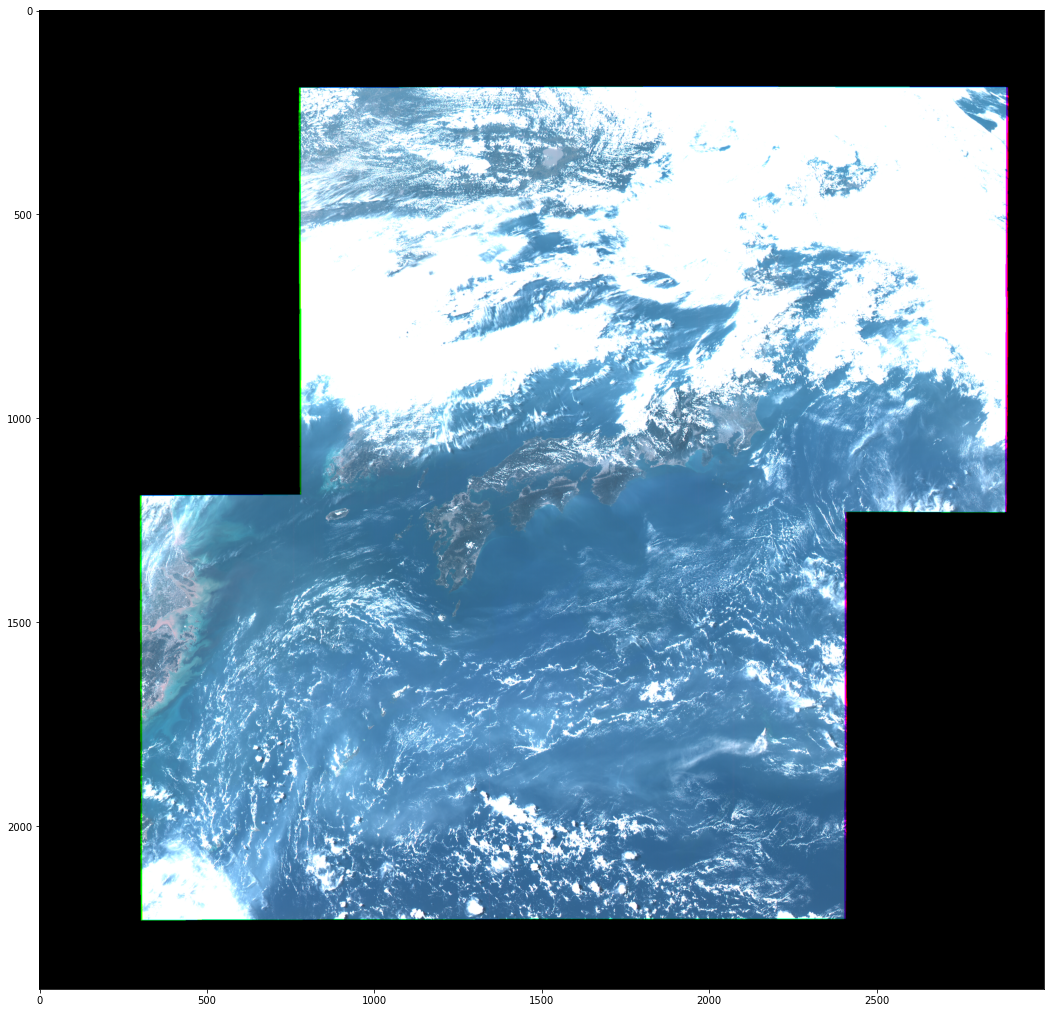

In [ ]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(data,aspect='auto')

In [ ]:
plt.close()